In [1790]:
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import scipy.optimize as optimize
import math
from google.cloud import bigquery
from time import sleep
from datetime import datetime,timedelta
from google.api_core.exceptions import BadRequest
from tqdm import tqdm, tqdm_notebook
from dateutil.relativedelta import relativedelta
from pandas import NaT
tqdm_notebook().pandas()
sns.set();

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../creds.json"

PROJECT = 'eng-reactor-287421'
dataset = 'MSRB'
table = 'msrb_with_ytw'

In [1791]:
def get_data():
    query = """
    
SELECT
  IFNULL(msrb.settlement_date,
    trade_date+2) AS settlement_date,
  msrb.trade_date,
  msrb.cusip,
  msrb.dated_date,
  msrb.dollar_price,
  msrb.trade_type,
  msrb.coupon AS coupon_rate,
  ice.interest_payment_frequency,
  ice.next_call_date,
  ice.next_call_price,
  msrb.maturity_date AS maturity_date,
  ice.previous_coupon_payment_date,
  ice.next_coupon_payment_date,
  ice.first_coupon_date,
  ice.coupon_type,
  ice.muni_security_type,
  ice.callable,
  msrb.yield
FROM
  `eng-reactor-287421.MSRB.msrb_trade_messages` AS msrb
INNER JOIN
  `eng-reactor-287421.reference_data.ytw_ice_ref_snapshot_20210113` AS ice
ON
  msrb.cusip = ice.CUSIP
WHERE
  msrb.trade_date = '2021-01-13'

  AND NOT ice.default_indicator
  AND ice.callable IS FALSE
  AND msrb.maturity_date > DATE_ADD(IFNULL(msrb.settlement_date,
      trade_date+2),INTERVAL 12 month)
    """
  #  AND msrb.coupon = 5
  #    AND msrb.yield BETWEEN 0 AND 10 
      #AND msrb.yield BETWEEN 0 AND 10 


     
    dataframe = (bqclient.query(query).result().to_dataframe())
    return dataframe



/Users/Gil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: PyarrowMissingWarning: Converting to a dataframe without pyarrow installed is often slower and will become unsupported in the future. Please install the pyarrow package.


Fixed rate                 1927
Original issue discount     118
Zero coupon                  53
Unknown                      42
Adjustable rate              22
Name: coupon_type, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


1927

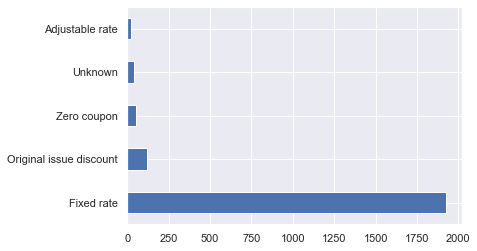

In [1792]:
bqclient = bigquery.Client()
muni_df = get_data()

muni_security_type_dict = {0:'Unknown',	1:'Short term discount',	2:'Fixed rate - unconfirmed',	3:'Adjustable rate',	4:'Zero coupon',	5:'Floating rate',	6:'Index Linked',	7:'Stepped coupon',	8:'Fixed rate',	9:'Stripped convertible',	10:'Deferred interest',	11:'Floating rate @ floor',	12:'Stripped tax credit',	13:'Inverse floating',	14:'Stripped coupon principal',	15:'Linked inverse floater',	16:'Flexible rate',	17:'Original issue discount',	18:'Stripped principal',	19:'Reserve CUSIP',	20:'Variable rate',	21:'Stripped coupon',	22:'Floating auction rate',	23:'Tax credit',	24:'Tax credit OID',	25:'Stripped coupon payment',	26:'Stepped up stepped down',	27:'Credit Sensitive',	28:'Pay in kind',	29:'Range',	30:'Digital',	31:'Reset'}
muni_df['muni_security_type']= muni_df['muni_security_type'].map(muni_security_type_dict) 

coupon_type_dict = {0:'Unknown',	1:'Short term discount',	2:'Fixed rate - unconfirmed',	3:'Adjustable rate',	4:'Zero coupon',	5:'Floating rate',	6:'Index Linked',	7:'Stepped coupon',	8:'Fixed rate',	9:'Stripped convertible',	10:'Deferred interest',	11:'Floating rate @ floor',	12:'Stripped tax credit',	13:'Inverse floating',	14:'Stripped coupon principal',	15:'Linked inverse floater',	16:'Flexible rate',	17:'Original issue discount',	18:'Stripped principal',	19:'Reserve CUSIP',	20:'Variable rate',	21:'Stripped coupon',	22:'Floating auction rate',	23:'Tax credit',	24:'Tax credit OID',	25:'Stripped coupon payment',	26:'Stepped up stepped down',	27:'Credit Sensitive',	28:'Pay in kind',	29:'Range',	30:'Digital',	31:'Reset'}
muni_df['coupon_type']= muni_df['coupon_type'].map(coupon_type_dict) 
muni_df["coupon_type"].unique()
print(muni_df["coupon_type"].value_counts())
print(muni_df["coupon_type"].value_counts().plot(kind = 'barh'))

frequency_dict_text = {0:'Unknown',	1:'Semiannually',	2:'Monthly',	3:'Annually',	4:'Weekly',	5:'Quarterly',	6:'Every 2 years',	7:'Every 3 years',	8:'Every 4 years',	9:'Every 5 years',	10:'Every 7 years',	11:'Every 8 years',	12:'Biweekly',	13:'Changeable',	14:'Daily',	15:'Term mode',	16:'Interest at maturity',	17:'Bimonthly',	18:'Every 13 weeks',	19:'Irregular',	20:'Every 28 days',	21:'Every 35 days',	22:'Every 26 weeks',	23:'Not Applicable',	24:'Tied to prime',	25:'One time',	26:'Every 10 years',	27:'Frequency to be determined',	28:'Mandatory put',	29:'Every 52 weeks',	30:'When interest adjusts-commercial paper',	31:'Zero coupon',	32:'Certain years only',	33:'Under certain circumstances',	34:'Every 15 years',	35:'Custom',	36:'Single Interest Payment'}
frequency_dict = {0:None,1:2,2:12,3:1,4:52,5:4,6:0.5,7:0.33333,8:0.25,9:0.2,10:1/7,11:1/8,13:44,14:360,16:0,23:0}
muni_df['interest_payment_frequency']= muni_df['interest_payment_frequency'].map(frequency_dict) 

muni_df['coupon_rate'] = muni_df['coupon_rate'].astype(float)
muni_df['next_call_price'] = muni_df['next_call_price'].astype(float)
muni_df["settlement_date"] = pd.to_datetime(muni_df["settlement_date"])
muni_df["first_coupon_date"] = pd.to_datetime(muni_df["first_coupon_date"])
muni_df["previous_coupon_payment_date"] = pd.to_datetime(muni_df["previous_coupon_payment_date"])
muni_df["next_coupon_payment_date"] = pd.to_datetime(muni_df["next_coupon_payment_date"])
muni_df["maturity_date"] = pd.to_datetime(muni_df["maturity_date"])

#muni_df = muni_df[muni_df.apply(lambda x: x["coupon_type"] in ['Fixed rate', 'Original issue discount', 'Zero coupon ',],axis=1)]
muni_df = muni_df[muni_df.apply(lambda x: x["coupon_type"] in ['Fixed rate',],axis=1)]
#muni_df = muni_df[muni_df.apply(lambda x: x["coupon_type"] in ['Zero coupon',],axis=1)]
#muni_df = muni_df[muni_df.apply(lambda x: x["coupon_type"] in ['FIXED', 'FIXED, OID', 'ZERO COUPON, OID',],axis=1)]
len(muni_df) #32,100 for Bloomberg Ref dated 11/30/2020 | 26,523 with ICE

In [1793]:
muni_df

,settlement_date,trade_date,cusip,dated_date,dollar_price,trade_type,coupon_rate,interest_payment_frequency,next_call_date,next_call_price,maturity_date,previous_coupon_payment_date,next_coupon_payment_date,first_coupon_date,coupon_type,muni_security_type,callable,yield
2,2021-01-15,2021-01-13,735000TN1,2020-12-03,102.606,P,1.517,2.0,None,NaN,2026-05-01,NaT,2021-05-01,2021-05-01,Fixed rate,Fixed rate,False,1.010
3,2021-01-15,2021-01-13,735000TN1,2020-12-03,102.606,P,1.517,2.0,None,NaN,2026-05-01,NaT,2021-05-01,2021-05-01,Fixed rate,Fixed rate,False,1.010
4,2021-01-15,2021-01-13,735000TN1,2020-12-03,102.559,P,1.517,2.0,None,NaN,2026-05-01,NaT,2021-05-01,2021-05-01,Fixed rate,Fixed rate,False,1.019
5,2021-01-15,2021-01-13,735000TN1,2020-12-03,102.694,P,1.517,2.0,None,NaN,2026-05-01,NaT,2021-05-01,2021-05-01,Fixed rate,Fixed rate,False,0.993
6,2021-01-15,2021-01-13,735000TN1,2020-12-03,102.711,S,1.517,2.0,None,NaN,2026-05-01,NaT,2021-05-01,2021-05-01,Fixed rate,Fixed rate,False,0.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2157,2021-01-15,2021-01-13,373283CH1,2018-02-22,111.003,D,5.000,2.0,None,NaN,2023-12-01,2020-12-01,2021-06-01,2018-12-01,Fixed rate,Adjustable rate,False,1.104
2158,2021-01-15,2021-01-13,64972CZ55,2018-04-19,104.007,D,3.021,2.0,None,NaN,2022-11-01,2020-11-01,2021-05-01,2018-11-01,Fixed rate,Fixed rate,False,0.768
2159,2021-01-15,2021-01-13,64972CZ55,2018-04-19,104.047,D,3.021,2.0,None,NaN,2022-11-01,2020-11-01,2021-05-01,2018-11-01,Fixed rate,Fixed rate,False,0.746
2160,2021-01-15,2021-01-13,64972CZ55,2018-04-19,104.647,S,3.021,2.0,None,NaN,2022-11-01,2020-11-01,2021-05-01,2018-11-01,Fixed rate,Fixed rate,False,0.419


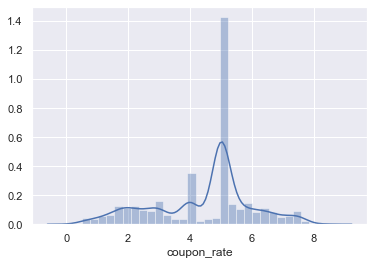

In [1794]:
sns.distplot(muni_df["coupon_rate"]);
fig = plt.gcf()

In [1795]:
def diff_in_days(end_date,start_date,daycount_convention):
    #MSRB Number of Days = (Y2 - Y1) 360 + (M2 - M1) 30 + (D2 - D1)
    difference_in_days = relativedelta(end_date, start_date).years*daycount_convention + relativedelta(end_date, start_date).months*30 + relativedelta(end_date, start_date).days
    return difference_in_days

In [1796]:
def get_next_coupon_date(first_cpn_date,start_date,time_delta):
    date = first_cpn_date
    while date < start_date:
        date = date + time_delta

    next_cpn_date = date
    return next_cpn_date

def get_previous_coupon_date(first_cpn_date,settlement_date,time_delta):
    date = first_cpn_date
    while date < settlement_date:
        date = date + time_delta

    prev_cpn_date = date - time_delta
    return prev_cpn_date

#get_next_coupon_date(pd.to_datetime('2021-01-01'),pd.to_datetime('2021-01-15'),relativedelta(months=6))
get_next_coupon_date(pd.to_datetime('2008-01-01'),pd.to_datetime('2021-01-15'),relativedelta(months=6))

Timestamp('2021-07-01 00:00:00')

In [1797]:
def old_yield_function(coupon,frequency,dt,par,dollar_price,guess,difference_in_years,):
    if len(dt)>0:
        ytm_func = lambda y: sum([coupon/((1+y/frequency)**(1*t)) for t in dt]) + par/((1+y/frequency)**(1*dt[len(dt)-1])) - dollar_price
    else:
        ytm_func = lambda y: par/((1+y/frequency)**(frequency*difference_in_years)) - dollar_price
    try:
        return round((optimize.newton(ytm_func, guess,maxiter = 100))*100,5)
    except Exception as e:
        print(e)
        return None

### A way to check correctness: 
done :: (N - 1)*E + (E-A) should equal the number of days from settlement to maturity. 
done :: (E-A) is the number of days until the next coupon date and N-1 is the number of periods from the next coupon date until the last coupon date, which (normally) is the same as the maturity date. 

RV/((1+Y/M)**(N-1+((E-A)/E))) is the present value of the redemption.
(100*R/M)/(1+Y/M)**(K-1+((E-A)/E)) is the present value of a single coupon.
(100*R)*(A/B) is how much the buyer must pay the seller at settlement, to bring the seller up-to-date on interest. This is the adjustment that converts the clean price P into the dirty price, which is what is actually paid.


In [1837]:
def get_yield(cusip,prev_coupon_date,first_coupon_date,next_coupon_date,end_date,settlement_date,dated_date,
              interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date,is_callable,guess):
    
    if first_coupon_date >= settlement_date: 
        next_coupon_date = first_coupon_date
    
    number_of_interest_payments = 0
    date = next_coupon_date
    # for every n months left before maturity, count an extra coupon payment period 
    while date <= end_date: # end_date: maturity_date or next_call_date
        number_of_interest_payments += 1
        date = date + time_delta

    N = number_of_interest_payments    
    final_coupon_date = date - time_delta
    D = diff_in_days(end_date,final_coupon_date,360)

    if pd.isnull(prev_coupon_date): prev_coupon_date = dated_date

    A = diff_in_days(settlement_date,prev_coupon_date,360) # accrued days from beginning of the interest payment period
    B = 360 # the number of days in the year (computed in accordance with the provisions of section (e) below);
    M = interest_payment_frequency 
    E = B/M # number of days in each full interest payment period 
    P = dollar_price # the dollar price of the security for each $100 par value;
    R = coupon_rate # the annual interest rate expressed as a percentage, i.e., dollars per $100;
    RV = par # the redemption value of the security per $100 par value; and
    # Y the yield price of the transaction (expressed as a decimal)
    
# the following function assumes that N >= 1 and needs more thought for N = 0
# same exponent (N-1 + (E-A)/E + D/E) as for RV
    ytm_func = lambda Y: RV / (1+Y/M)**(N-1 + (E-A)/E + D/E) + sum([ (R/M) / (1+Y/M)**(K + (E-A)/E) for K in range(N)]) +   (R*D/B)  / (1+Y/M)**(N-1 + (E-A)/E + D/E)  - (P + R*A/B)   
    try:
        return round(optimize.newton(ytm_func, guess,maxiter = 100)*100,3)
    except Exception as e:
        print(e)
        return None

In [1838]:
def compute_yield(settlement_date,cusip,security_typ,dated_date,dollar_price,trade_type,coupon_rate,interest_payment_frequency,next_call_date,next_call_price,maturity_date,previous_coupon_payment_date,next_coupon_payment_date,first_coupon_date,coupon_type,trade_date,is_callable,guess):
    #add ice/my to parameters names 
    #raise an error if interest_payment_frequency does not divide into 12: 
    if interest_payment_frequency != 0: 
        #delta = 12/interest_payment_frequency 
        if interest_payment_frequency <= 12:
            delta = 12/interest_payment_frequency
            time_delta = relativedelta(months=delta)
        elif interest_payment_frequency > 12 and interest_payment_frequency <= 52:
            delta = 52/interest_payment_frequency
            time_delta = relativedelta(weeks=delta)
    else: 
        delta = None

    time_delta = relativedelta(months=delta)
    
    next_coupon_date = pd.to_datetime(next_coupon_payment_date)
    prev_coupon_date = pd.to_datetime(previous_coupon_payment_date)

    if (pd.isnull(previous_coupon_payment_date)):
        prev_coupon_date = get_previous_coupon_date(first_coupon_date,settlement_date,time_delta)
    if  (pd.isnull(next_coupon_payment_date)):
        next_coupon_date = get_next_coupon_date(first_coupon_date,settlement_date,time_delta)
    if next_coupon_payment_date < settlement_date and pd.isnull(previous_coupon_payment_date):
        next_coupon_date = get_next_coupon_date(first_coupon_date,settlement_date,time_delta)
         
    if pd.isnull(next_call_date) or pd.isnull(next_call_price):
        end_date = maturity_date
        par = 100
        ytm = get_yield(cusip,prev_coupon_date,first_coupon_date,next_coupon_date,end_date,settlement_date,dated_date,interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date,is_callable,guess)
        return ytm
    else:
        end_date = next_call_date
        par = next_call_price
        ytf = get_yield(cusip,prev_coupon_date,first_coupon_date,next_coupon_date,end_date,settlement_date,dated_date,interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date,is_callable,guess)
        end_date = maturity_date
        par = 100
        ytm = get_yield(cusip,prev_coupon_date,first_coupon_date,next_coupon_date,end_date,settlement_date,dated_date,interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date,is_callable,guess)
        if ytm < ytf:
            return ytm
        else:
            return ytf

temp = None
temp = muni_df.head(n=10)
guess = 0.05
temp['computed_ytw'] = temp.progress_apply(lambda x: compute_yield(x['settlement_date'],	x['cusip'],	x['muni_security_type'],	x['dated_date'],	x['dollar_price'],	x['trade_type'],	x['coupon_rate'],	x['interest_payment_frequency'],	x['next_call_date'],	x['next_call_price'],	x['maturity_date'],	x['previous_coupon_payment_date'],	x['next_coupon_payment_date'],	x['first_coupon_date'],	x['coupon_type'],x['trade_date'],x['callable'],guess),axis=1)
temp

/Users/Gil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,settlement_date,trade_date,cusip,dated_date,dollar_price,trade_type,coupon_rate,interest_payment_frequency,next_call_date,next_call_price,maturity_date,previous_coupon_payment_date,next_coupon_payment_date,first_coupon_date,coupon_type,muni_security_type,callable,yield,computed_ytw,ytw_delta
2,2021-01-15,2021-01-13,735000TN1,2020-12-03,102.606,P,1.517,2.0,None,NaN,2026-05-01,NaT,2021-05-01,2021-05-01,Fixed rate,Fixed rate,False,1.010,1.010,0.0002
3,2021-01-15,2021-01-13,735000TN1,2020-12-03,102.606,P,1.517,2.0,None,NaN,2026-05-01,NaT,2021-05-01,2021-05-01,Fixed rate,Fixed rate,False,1.010,1.010,0.0002
4,2021-01-15,2021-01-13,735000TN1,2020-12-03,102.559,P,1.517,2.0,None,NaN,2026-05-01,NaT,2021-05-01,2021-05-01,Fixed rate,Fixed rate,False,1.019,1.019,0.0002
5,2021-01-15,2021-01-13,735000TN1,2020-12-03,102.694,P,1.517,2.0,None,NaN,2026-05-01,NaT,2021-05-01,2021-05-01,Fixed rate,Fixed rate,False,0.993,0.993,0.0003
6,2021-01-15,2021-01-13,735000TN1,2020-12-03,102.711,S,1.517,2.0,None,NaN,2026-05-01,NaT,2021-05-01,2021-05-01,Fixed rate,Fixed rate,False,0.990,0.990,0.0001
7,2021-01-15,2021-01-13,735000TN1,2020-12-03,102.606,P,1.517,2.0,None,NaN,2026-05-01,NaT,2021-05-01,2021-05-01,Fixed rate,Fixed rate,False,1.010,1.010,0.0002
8,2021-01-15,2021-01-13,735000TN1,2020-12-03,102.659,S,1.517,2.0,None,NaN,2026-05-01,NaT,2021-05-01,2021-05-01,Fixed rate,Fixed rate,False,1.000,1.000,0.0000
9,2021-01-15,2021-01-13,735000TN1,2020-12-03,102.580,P,1.517,2.0,None,NaN,2026-05-01,NaT,2021-05-01,2021-05-01,Fixed rate,Fixed rate,False,1.015,1.015,0.0002
11,2021-01-15,2021-01-13,64990BYC1,2016-04-13,127.463,S,5.000,2.0,None,NaN,2027-08-15,2020-08-15,2021-02-15,2017-02-15,Fixed rate,Fixed rate,False,0.721,0.721,0.0000
12,2021-01-15,2021-01-13,9397202L1,2020-07-21,115.256,P,5.000,2.0,None,NaN,2024-07-01,2021-01-01,2021-07-01,2021-01-01,Fixed rate,Adjustable rate,False,0.544,0.544,0.0004


In [1839]:
# Generate YTW
guess = 0.05

muni_df['computed_ytw'] = muni_df.progress_apply(lambda x: compute_yield(x['settlement_date'],	x['cusip'],	x['muni_security_type'],	x['dated_date'],	x['dollar_price'],	x['trade_type'],	x['coupon_rate'],	x['interest_payment_frequency'],	x['next_call_date'],	x['next_call_price'],	x['maturity_date'],	x['previous_coupon_payment_date'],	x['next_coupon_payment_date'],	x['first_coupon_date'],	x['coupon_type'],x['trade_date'],x['callable'],guess),axis=1)

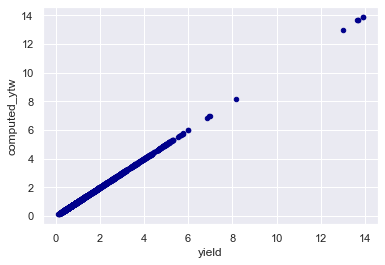

In [1840]:
ax1 = muni_df.plot.scatter(x='yield',
                     y='computed_ytw',
                       c='DarkBlue')

In [1841]:
#muni_df.insert(7,'delta',muni_df['computed_ytw'] - muni_df['yield'])
muni_df['ytw_delta'] = muni_df['computed_ytw'] - muni_df['yield']
#muni_df.to_csv(r'results.csv')

In [1847]:
delta = muni_df.sort_values(by=['ytw_delta'])#, ascending=False)
delta[:50] #.head(n=40) 041438GR7
#delta[delta['cusip'] == '649845HD9']

,settlement_date,trade_date,cusip,dated_date,dollar_price,trade_type,coupon_rate,interest_payment_frequency,next_call_date,next_call_price,maturity_date,previous_coupon_payment_date,next_coupon_payment_date,first_coupon_date,coupon_type,muni_security_type,callable,yield,computed_ytw,ytw_delta
712,2021-01-14,2021-01-13,70917SWN9,2016-06-07,106.165,P,5.000,2.0,None,NaN,2022-06-15,2020-12-15,2021-06-15,2016-12-15,Fixed rate,Fixed rate,False,0.630,0.622,-0.008
1031,2021-01-14,2021-01-13,79904NFA3,2016-01-28,106.664,P,5.000,2.0,None,NaN,2022-07-15,2020-07-15,2021-01-15,2016-07-15,Fixed rate,Adjustable rate,False,0.541,0.534,-0.007
1392,2021-01-14,2021-01-13,574295EG2,2012-11-15,111.321,S,5.000,2.0,None,NaN,2023-06-15,2020-12-15,2021-06-15,2012-12-15,Fixed rate,Adjustable rate,False,0.300,0.295,-0.005
1472,2021-01-14,2021-01-13,59259YWW5,2008-02-21,106.013,P,5.000,2.0,None,NaN,2022-11-15,2020-11-15,2021-05-15,2013-05-15,Fixed rate,Fixed rate,False,1.660,1.655,-0.005
768,2021-01-14,2021-01-13,762197SK8,2016-10-18,119.004,P,5.000,2.0,None,NaN,2025-09-15,2020-09-15,2021-03-15,2017-03-15,Fixed rate,Fixed rate,False,0.841,0.839,-0.002
436,2021-01-14,2021-01-13,89602N7V0,2017-01-19,125.196,D,5.000,2.0,None,NaN,2026-11-15,2020-11-15,2021-05-15,2017-05-15,Fixed rate,Fixed rate,False,0.600,0.598,-0.002
437,2021-01-14,2021-01-13,89602N7V0,2017-01-19,125.196,P,5.000,2.0,None,NaN,2026-11-15,2020-11-15,2021-05-15,2017-05-15,Fixed rate,Fixed rate,False,0.600,0.598,-0.002
227,2021-01-14,2021-01-13,91412GTF2,2013-10-02,110.302,P,3.789,2.0,None,NaN,2024-05-15,2020-11-15,2021-05-15,2014-05-15,Fixed rate,Fixed rate,False,0.661,0.659,-0.002
214,2021-01-15,2021-01-13,686053GG8,2005-06-21,115.650,S,4.759,2.0,None,NaN,2028-06-30,2020-12-30,2021-06-30,2005-12-30,Fixed rate,Index Linked,False,2.450,2.449,-0.001
215,2021-01-15,2021-01-13,686053GG8,2005-06-21,115.650,S,4.759,2.0,None,NaN,2028-06-30,2020-12-30,2021-06-30,2005-12-30,Fixed rate,Index Linked,False,2.450,2.449,-0.001


In [1843]:
A=14
B=360
M=2.0
E=180.0
N=6
P=113.001
R=0.05
RV=100
Y=0.566
dt= [1, 2, 3, 4, 5, 6]
RV/((1+Y/M)**(N-1+((E-A)/E)))+sum([(100*R/M)/(1+Y/M)**(K-1+((E-A)/E)) for K in dt])-(100*A/B*R) 

29.6520456413846

In [1853]:
muni_df[muni_df['computed_ytw'] == muni_df['yield']]
#muni_df["computed_ytw"].corr(muni_df["yield"])

,settlement_date,trade_date,cusip,dated_date,dollar_price,trade_type,coupon_rate,interest_payment_frequency,next_call_date,next_call_price,maturity_date,previous_coupon_payment_date,next_coupon_payment_date,first_coupon_date,coupon_type,muni_security_type,callable,yield,computed_ytw,ytw_delta
2,2021-01-15,2021-01-13,735000TN1,2020-12-03,102.606,P,1.517,2.0,None,NaN,2026-05-01,NaT,2021-05-01,2021-05-01,Fixed rate,Fixed rate,False,1.010,1.010,0.0
3,2021-01-15,2021-01-13,735000TN1,2020-12-03,102.606,P,1.517,2.0,None,NaN,2026-05-01,NaT,2021-05-01,2021-05-01,Fixed rate,Fixed rate,False,1.010,1.010,0.0
4,2021-01-15,2021-01-13,735000TN1,2020-12-03,102.559,P,1.517,2.0,None,NaN,2026-05-01,NaT,2021-05-01,2021-05-01,Fixed rate,Fixed rate,False,1.019,1.019,0.0
5,2021-01-15,2021-01-13,735000TN1,2020-12-03,102.694,P,1.517,2.0,None,NaN,2026-05-01,NaT,2021-05-01,2021-05-01,Fixed rate,Fixed rate,False,0.993,0.993,0.0
6,2021-01-15,2021-01-13,735000TN1,2020-12-03,102.711,S,1.517,2.0,None,NaN,2026-05-01,NaT,2021-05-01,2021-05-01,Fixed rate,Fixed rate,False,0.990,0.990,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2157,2021-01-15,2021-01-13,373283CH1,2018-02-22,111.003,D,5.000,2.0,None,NaN,2023-12-01,2020-12-01,2021-06-01,2018-12-01,Fixed rate,Adjustable rate,False,1.104,1.104,0.0
2158,2021-01-15,2021-01-13,64972CZ55,2018-04-19,104.007,D,3.021,2.0,None,NaN,2022-11-01,2020-11-01,2021-05-01,2018-11-01,Fixed rate,Fixed rate,False,0.768,0.768,0.0
2159,2021-01-15,2021-01-13,64972CZ55,2018-04-19,104.047,D,3.021,2.0,None,NaN,2022-11-01,2020-11-01,2021-05-01,2018-11-01,Fixed rate,Fixed rate,False,0.746,0.746,0.0
2160,2021-01-15,2021-01-13,64972CZ55,2018-04-19,104.647,S,3.021,2.0,None,NaN,2022-11-01,2020-11-01,2021-05-01,2018-11-01,Fixed rate,Fixed rate,False,0.419,0.419,0.0


In [1846]:
1809/len(muni_df)

0.9387649195640893